<a href="https://colab.research.google.com/github/Pakopac/houseNumbers-recognition/blob/master/MonkeySpecies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome in this notebook of the project ML recognition monkey species. \
Here we will describe step by step how to build a CNN model to a make a prediction of a specie of monkey from an image. \

First we need to import the librairies needed. 

In [65]:
# Utils
import sys
import os
import shutil
import time
import pickle
import numpy as np
import h5py
import pandas as pd
import seaborn as sns

# Deep Learning Librairies
import tensorflow as tf
import keras.preprocessing.image as kpi
import keras.layers as kl
import keras.optimizers as ko
import keras.backend as k
import keras.models as km
import keras.applications as ka

# Data Visualization
from matplotlib import pyplot as plt

In [66]:
# GPU mode for colab notebook
from tensorflow.python.client import device_lib
MODE = "GPU" if "GPU" in [k.device_type for k in device_lib.list_local_devices()] else "CPU"

I'm importing datas from my drive, I got the datas here: https://www.kaggle.com/slothkong/10-monkey-species

In [67]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Colab_Notebooks/monkey/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define hyperparameters here.

In [68]:
# Number trained/test images for model
N_train = 200
N_val = 80
# Image size for model
img_width = 150
img_height = 150
# Number of time iterate
epochs=5
batch_size=10

Informations per species are listed in monkey_labels.txt with the label, the names, the number of train images and the number of validations images

In [69]:
# We define columns and display as a pandas dataframe
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
df = pd.read_csv(data_dir + "monkey_labels.txt", names=cols, skiprows=1)
df

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


We can check the proportion of images of each species as a diagram. \
We have about the same values, in train we have between 130 and 150 images of each and in test we have between 25 and 30 images

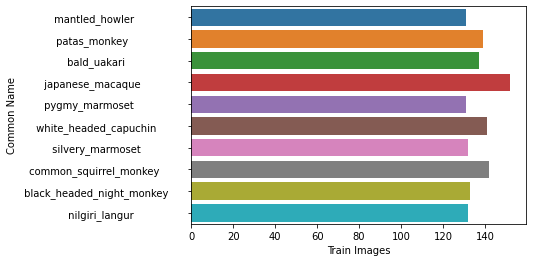

In [70]:
sns.barplot(x = df["Train Images"], y = df["Common Name"])
plt.show()

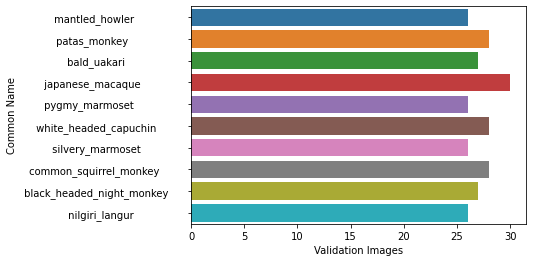

In [71]:
sns.barplot(x = df["Validation Images"], y = df["Common Name"])
plt.show()

We can load an image with kpi.load_image and convert to an array to test the render of image

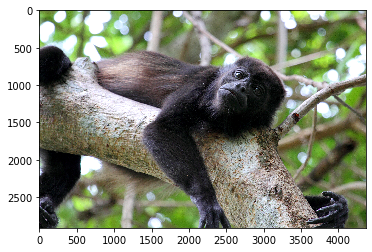

In [72]:
img = kpi.load_img(data_dir+'training/training/n0/n0021.jpg')
x = kpi.img_to_array(img)  
plt.imshow(x/255, interpolation='nearest')
plt.show()

As we can see images are not the same size, we need the same size for our model 

In [73]:
x_0 = kpi.img_to_array(kpi.load_img(data_dir+"training/training/n0/n0021.jpg"))
x_1 = kpi.img_to_array(kpi.load_img(data_dir+"training/training/n0/n0022.jpg"))
x_0.shape, x_1.shape

((2911, 4367, 3), (1900, 1526, 3))

In [74]:
datagen = kpi.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [75]:
img_width = 150
img_height = 150

img = kpi.load_img(data_dir+"training/training/n0/n0021.jpg")  # this is a PIL image
x = kpi.img_to_array(img)  
x_ = x.reshape((1,) + x.shape)

if not(os.path.isdir(data_dir+"preprocessing_example")):
    os.mkdir(data_dir+"preprocessing_example")

    i = 0
    for batch in datagen.flow(x_, batch_size=1,save_to_dir=data_dir+"preprocessing_example", save_prefix='monkey', save_format='jpg'):
        i += 1
        if i > 8:
            break  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


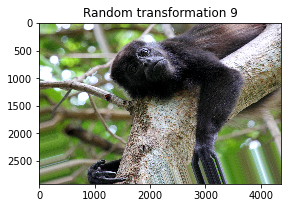

In [76]:
X_list=[]
for f in os.listdir(data_dir+"preprocessing_example"):
    X_list.append(kpi.img_to_array(kpi.load_img(data_dir+"preprocessing_example/"+f)))

fig=plt.figure(figsize=(16,8))
fig.patch.set_alpha(0)
ax = fig.add_subplot(3,3,1)
ax.imshow(x/255, interpolation="nearest")
ax.set_title("Image original")
for i,xt in enumerate(X_list):
    ax = fig.add_subplot(3,3,1)
    ax.imshow(xt/255, interpolation="nearest")
    ax.set_title("Random transformation %d" %(i+1))
plt.tight_layout()
plt.savefig("monkeys_transformation.png", dpi=100, bbox_to_anchor="tight", facecolor=fig.get_facecolor())
plt.show()

In [110]:
# this is the augmentation configuration we will use for training
train_datagen = kpi.ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
valid_datagen = kpi.ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        data_dir+"/training/training",  # this is the target directory
        target_size=(img_width, img_height),  
        batch_size=64,
        shuffle=True,
        seed=100,
        class_mode='categorical')

# this is a similar generator, for validation data
validation_generator = valid_datagen.flow_from_directory(
        data_dir+"/validation/validation",
        target_size=(img_width, img_height),
        batch_size=64,
        shuffle=True,
        seed=100,
        class_mode='categorical')

Found 895 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [124]:
model = km.Sequential()
model.add(kl.Conv2D(32, (3, 3), input_shape=(150, 150, 3), strides=2))
model.add(kl.Activation('relu'))

model.add(kl.BatchNormalization())
model.add(kl.Conv2D(32, (3, 3), strides=2))
model.add(kl.Activation('relu'))

model.add(kl.BatchNormalization())
model.add(kl.Conv2D(64, (3, 3)))
model.add(kl.Activation('relu'))
model.add(kl.BatchNormalization())
model.add(kl.Conv2D(64, (3, 3), strides=2))
model.add(kl.Activation('relu'))

model.add(kl.Conv2D(512, (1, 1), strides=2))
model.add(kl.Activation('relu'))
model.add(kl.Conv2D(10, (1, 1)))
model.add(kl.GlobalAvgPool2D())
model.add(kl.Activation('softmax'))

model_conv.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])


model_conv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                    

In [121]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
filepath=(data_dir + "monkey.h5f")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# = EarlyStopping(monitor='val_acc', patience=15)
callbacks_list = [checkpoint]#, stopper]

history = model_conv.fit_generator(train_generator,
                              steps_per_epoch= train_generator.samples // 64,
                              epochs=50,
                              validation_data=train_generator,
                              validation_steps= validation_generator.samples // 64,
                              callbacks=callbacks_list, 
                              verbose = 1
                             )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 1/50


InvalidArgumentError: ignored

In [113]:
ts = time.time()
model_conv.fit_generator(train_generator, steps_per_epoch=N_train // batch_size, epochs=epochs,
       validation_data=validation_generator,validation_steps=N_val // batch_size)
te = time.time()
t_learning_conv_simple_model = te-ts
print("Learning Time for %d epochs : %d seconds"%(epochs,t_learning_conv_simple_model))
model_conv.save(data_dir+'/'+MODE+'_models_convolutional_network_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/5


InvalidArgumentError: ignored

In [19]:
ts = time.time()
score_conv_val = model_conv.evaluate_generator(validation_generator, N_val /batch_size, verbose=1)
score_conv_train = model_conv.evaluate_generator(train_generator, N_train / batch_size, verbose=1)
te = time.time()
t_prediction_conv_simple_model = te-ts
print('Train accuracy:', score_conv_train[1])
print('Validation accuracy:', score_conv_val[1])
print("Time Prediction: %.2f seconds" %t_prediction_conv_simple_model )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


8/8 [==============================] - 6s 821ms/step - loss: -148427344.0000 - accuracy: 0.1125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


20/20 [==============================] - 15s 781ms/step - loss: -125557608.0000 - accuracy: 0.1200
Train accuracy: 0.11999999731779099
Validation accuracy: 0.11249999701976776
Time Prediction: 27.30 seconds


In [20]:
model_VGG16_without_top = ka.vgg16.VGG16(include_top=False, weights='imagenet')
model_VGG16_without_top.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [40]:
features_train_path = data_dir+'/features_train.npy' 
features_validation_path = data_dir+'/features_validation.npy' 

if os.path.isfile(features_train_path) and os.path.isfile(features_validation_path):
    print("Load Features")
    features_train = np.load(open(features_train_path, "rb"))
    features_validation = np.load(open(features_validation_path, "rb"))
    
else:
    print("Generate Features")
    datagen = kpi.ImageDataGenerator(rescale=1. / 255)

    generator = datagen.flow_from_directory(
            data_dir+"/training/training",
            target_size=(img_width, img_height),
            batch_size=batch_size,
            shuffle=False)  
    features_train = model_VGG16_without_top.predict_generator(generator, N_train / batch_size,  verbose = 1)
    # save the output as a Numpy array
    np.save(open(features_train_path, 'wb'), features_train)

    
    generator = datagen.flow_from_directory(
        data_dir+"/validation/validation",
            target_size=(img_width, img_height),
            batch_size=batch_size,

            shuffle=False)
    features_validation = model_VGG16_without_top.predict_generator(generator, N_val / batch_size,  verbose = 1)
    # save the output as a Numpy array
    np.save(open(features_validation_path, 'wb'), features_validation)

Load Features


In [41]:
model_VGG_fcm = km.Sequential()
model_VGG_fcm.add(kl.Flatten(input_shape=features_train.shape[1:]))
model_VGG_fcm.add(kl.Dense(64, activation='relu'))
model_VGG_fcm.add(kl.Dropout(0.5))
model_VGG_fcm.add(kl.Dense(1, activation='sigmoid'))

model_VGG_fcm.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_VGG_fcm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                1179712   
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,179,777
Trainable params: 1,179,777
Non-trainable params: 0
_________________________________________________________________


In [42]:
# On créer des vecteurs labels

train_labels = np.array([0] * int((N_train/2)) + [1] * int((N_train/2)))
validation_labels = np.array([0] * int((N_val/2)) + [1] * int((N_val/2)))

model_VGG_fcm.fit(features_train, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(features_validation, validation_labels))
t_learning_VGG_fcm = te-ts

Epoch 1/5
20/20 [==============================] - 1s 10ms/step - loss: 5.2644 - accuracy: 0.8400 - val_loss: 15.9041 - val_accuracy: 0.5500
Epoch 2/5
20/20 [==============================] - 0s 5ms/step - loss: 1.6970 - accuracy: 0.9350 - val_loss: 10.1489 - val_accuracy: 0.7750
Epoch 3/5
20/20 [==============================] - 0s 4ms/step - loss: 0.3361 - accuracy: 0.9650 - val_loss: 10.8565 - val_accuracy: 0.7000
Epoch 4/5
20/20 [==============================] - 0s 4ms/step - loss: 0.8537 - accuracy: 0.9450 - val_loss: 8.7096 - val_accuracy: 0.6625
Epoch 5/5
20/20 [==============================] - 0s 4ms/step - loss: 0.5336 - accuracy: 0.9450 - val_loss: 8.7993 - val_accuracy: 0.5875


In [43]:
model_VGG_fcm.save_weights(data_dir+'/weights_model_VGG_fully_connected_model_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))


In [44]:
ts = time.time()
score_VGG_fcm_val = model_VGG_fcm.evaluate(features_validation, validation_labels)
score_VGG_fcm_train = model_VGG_fcm.evaluate(features_train, train_labels)
te = time.time()
t_prediction_VGG_fcm = te-ts
print('Train accuracy:', score_VGG_fcm_train[1])
print('Validation accuracy:', score_VGG_fcm_val[1])
print("Time Prediction: %.2f seconds" %t_prediction_VGG_fcm)

7/7 [==============================] - 0s 3ms/step - loss: 0.0713 - accuracy: 0.9850
Train accuracy: 0.9850000143051147
Validation accuracy: 0.5874999761581421
Time Prediction: 0.26 seconds


In [56]:
from keras.preprocessing.image import load_img
# load an image from file
image = load_img('/content/drive/MyDrive/Colab_Notebooks/monkey/validation/validation/n0/n000.jpg', target_size=(224, 224))


In [57]:
from keras.preprocessing.image import img_to_array
# convert the image pixels to a numpy array
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

In [58]:
from keras.applications.vgg16 import preprocess_input
# prepare the image for the VGG model
image = preprocess_input(image)

In [59]:
model.predict(image)

array([[7.07289663e-16, 3.86845072e-15, 1.22124747e-16, 7.85551392e-17,
        7.25151629e-16, 1.60698684e-13, 5.31229164e-15, 1.67725903e-11,
        2.03760949e-11, 1.08182858e-13, 2.56277950e-14, 2.47983762e-13,
        3.10316036e-13, 1.23422529e-12, 4.58805693e-12, 2.05115460e-12,
        2.89207872e-12, 3.33793605e-12, 4.07853092e-12, 8.97433915e-14,
        1.05399571e-14, 4.82527516e-12, 6.54168797e-15, 3.12864110e-11,
        2.63270638e-11, 1.51018521e-14, 5.15344095e-14, 4.93398703e-16,
        3.63848424e-15, 1.50436643e-14, 1.01827679e-13, 8.56149529e-14,
        6.06707406e-14, 1.72019951e-16, 5.28362874e-17, 1.45487409e-13,
        1.06786968e-13, 1.85212190e-14, 1.52570513e-16, 2.06273215e-12,
        1.29270975e-12, 3.02632878e-14, 4.75508738e-13, 9.24920349e-11,
        1.74215153e-15, 7.87697696e-15, 3.45810972e-13, 3.06166052e-12,
        5.41925107e-14, 1.45682264e-14, 2.05910088e-15, 1.98713540e-14,
        1.40658452e-14, 6.55885351e-15, 1.83561971e-15, 3.378614

In [63]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
# load the model
model = VGG16()
# load an image from file
image = load_img('/content/drive/MyDrive/Colab_Notebooks/monkey/monkeyTest.jpeg', target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
# predict the probability across all output classes
yhat = model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

guenon (88.59%)
